In [1]:
#Import Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [82]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [68]:
#Inspect Column Names and Types for the Measurement Table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [25]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

'2017-08-23'

<AxesSubplot:xlabel='Date', ylabel='Inches'>

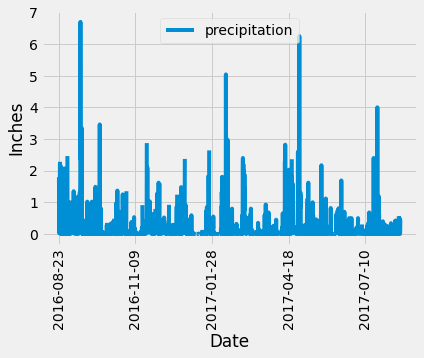

In [154]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# Calculate the date one year from the last date in data set.
recent_date = recent_date.split('-')
recent_date = [int(recent_date[i]) for i in range(0,len(recent_date))]
prior_year = dt.date(recent_date[0],recent_date[1], recent_date[2]) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prior_year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(results,columns=['date','precipitation'])
precipitation_df.set_index('date', inplace=True)
# Sort the dataframe by date
precipitation_df.sort_index(inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(
    y='precipitation',
    xlabel = 'Date',
    ylabel= 'Inches',
    rot=90
)

In [58]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [97]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).count()

9

In [69]:
#Inspect Column Names and Types for the Station Table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [105]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activity = session.query(Station.id, Measurement.station, func.count(Measurement.tobs))\
    .filter(Station.station == Measurement.station)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.tobs).desc()).all()
for station in activity:
    print(f'ID: {station[0]} Station: {station[1]} Observations: {station[2]}')

ID: 7 Station: USC00519281 Observations: 2772
ID: 1 Station: USC00519397 Observations: 2724
ID: 2 Station: USC00513117 Observations: 2709
ID: 6 Station: USC00519523 Observations: 2669
ID: 9 Station: USC00516128 Observations: 2612
ID: 3 Station: USC00514830 Observations: 2202
ID: 8 Station: USC00511918 Observations: 1979
ID: 4 Station: USC00517948 Observations: 1372
ID: 5 Station: USC00518838 Observations: 511


In [130]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = activity[0][0]
temps = session.query(Measurement.tobs)\
    .filter(Station.station == Measurement.station)\
    .filter(Station.id == active_station).all()
min_temp = min(temps)[0]
max_temp = max(temps)[0]
mean_temp = session.query(func.round(func.avg(Measurement.tobs),1))\
    .filter(Station.station == Measurement.station)\
    .filter(Station.id == active_station).first()[0]
print(f'For Station {active_station}, the low temperature is {min_temp}, the high temperature is {max_temp}, and the average temperature is {mean_temp}.')

For Station 7, the low temperature is 54.0, the high temperature is 85.0, and the average temperature is 71.7.


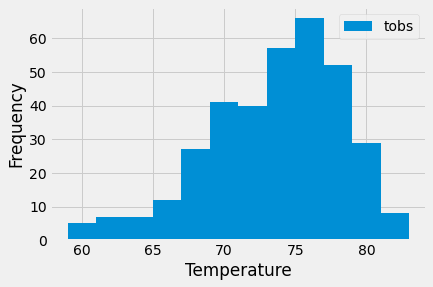

In [139]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temps = session.query(Measurement.tobs)\
    .filter(Station.station == Measurement.station)\
    .filter(Measurement.date > prior_year)\
    .filter(Station.id == active_station).all()

tobs = []

for i in range(0,len(year_temps)):
    tobs.append(year_temps[i][0])

plt.hist(tobs, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Close session

In [140]:
# Close Session
session.close()